# LLM Assessment of Occupations

In [1]:
! pip install --quiet git+https://github.com/expectedparrot/edsl.git
! pip install --quiet networkx


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
from question_bank import task_survey

In [2]:
from textwrap import dedent
import copy
import random

from edsl.questions import QuestionCheckBox, QuestionFreeText
from edsl import Scenario, Model
from edsl.questions import QuestionMultipleChoice
from itertools import combinations
from edsl.questions.derived.QuestionLinearScale import QuestionLinearScale
from textwrap import dedent

Model.available()
m35 = Model('gpt-3.5-turbo')
m4 = Model('gpt-4-1106-preview')

# Examples with fake data

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_dag(data):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges based on the dictionary structure
    for key, values in data.items():
        for value in values:
            G.add_edge(key, value)

    # Draw the DAG
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=15, width=2.5, edge_color='gray')
    plt.title("Directed Acyclic Graph (DAG)")
    plt.show()
    

For each occupation and focal task, we can exact tasks it is inputs to.

In [5]:
occupation = "Sandwich artist"
options = ["Slice bread", "Spread mayo", "Add meats and cheese", "Wrap sandwich", "Take payment"]

def draw_dag_line(occupation, focal_task, all_tasks):
    tasks = copy.deepcopy(all_tasks)
    tasks.remove(focal_task)
    q = QuestionCheckBox(
        question_name = "dag",
        question_text = dedent("""\
            Consider this {{ occupation }}. 
            And consider this task: {{ task }}. 
            Of the following tasks, which task is this task an input to? 
            Check all that apply.
            """),
        question_options = tasks
    )
    scenario = Scenario({'occupation':occupation, 'task': focal_task})
    return q.by(m4).by(scenario).run()

def draw_dag(occupation, tasks):
    dag = dict({})
    for task in tasks: 
        dag[task] = draw_dag_line(occupation, task, tasks).select("dag").first()
    return dag


sandwich_dag = draw_dag("Sandwich artist", options)
plot_dag(sandwich_dag)

NameError: name 'plot_dag' is not defined

# Pair-wise ordering: Identifying sub-tasks

We can take each task in the collection and get every unique pair. We can then ask what order they are done in, if at all. 

In [5]:
options = ["Slice bread", "Spread mayo", "Add meats and cheese", "Wrap sandwich", "Take payment", "Sweep shop"]

def task_relationships(occupation, tasks):
    random.shuffle(tasks)
    scenarios = [Scenario({"occupation": occupation, "task_A": task_A, "task_B": task_B}) 
        for task_A, task_B in combinations(tasks, 2)]

    q = QuestionMultipleChoice(
        question_name = "ordering",
        question_text = dedent("""\
            Consider this {{ occupation }}. 
            And consider these two tasks: 
            A) {{ task_A }} 
            B) {{ task_B }}
            What is the relationship between these tasks?
            """),
        question_options = [
            "A would be done first", 
            "B would be done first", 
            "Could be done in either order, but still part of the same task", 
            "Not part of the same task sequence"]
    )
    results = q.by(m4).by(scenarios).run(progress_bar = True)
    return results

results = task_relationships("Heart surgeon", options)
results.select("task_A", "task_B", "ordering").print()

Output()

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario      ┃ scenario             ┃ answer                             ┃
┃ .task_A       ┃ .task_B              ┃ .ordering                          ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Spread mayo   │ Slice bread          │ B would be done first              │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Spread mayo   │ Wrap sandwich        │ A would be done first              │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Spread mayo   │ Sweep shop           │ Not part of the same task sequence │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Spread mayo   │ Add meats and cheese │ A would be done first              │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Take payment  │ Slice bread          │ Not part of the same task sequence │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Take payment  │ Wrap sandwich        │ Not part of the same task sequence │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Take payment  │ Sweep shop           │ Not part of the same task sequence │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Take payment  │ Add meats and cheese │ Not part of the same task sequence │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Slice bread   │ Wrap sandwich        │ Not part of the same task sequence │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Slice bread   │ Sweep shop           │ Not part of the same task sequence │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Slice bread   │ Add meats and cheese │ A would be done first              │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Sweep shop    │ Add meats and cheese │ Not part of the same task sequence │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Wrap sandwich │ Add meats and cheese │ B would be done first              │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Spread mayo   │ Take payment         │ Not part of the same task sequence │
├───────────────┼──────────────────────┼────────────────────────────────────┤
│ Wrap sandwich │ Sweep shop           │ Not part of the same task sequence │
└───────────────┴──────────────────────┴────────────────────────────────────┘

In [ ]:
results.select("task_A", "task_B",'answer.*').print()

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario             ┃ scenario             ┃ answer                          ┃ answer                          ┃
┃ .task_A              ┃ .task_B              ┃ .ordering_comment               ┃ .ordering                       ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Take payment         │ Spread mayo          │ Taking payment is a task        │ Not part of the same task       │
│                      │                      │ related to the administrative   │ sequence                        │
│                      │                      │ or financial aspects of a heart │                                 │
│                      │                      │ surgeon's services. Spreading   │                                 │
│                      │                      │ mayo is a task that is not      │                                 │
│                      │                      │ related to the typical duties   │                                 │
│                      │                      │ of a heart surgeon and is       │                                 │
│                      │                      │ likely associated with food     │                                 │
│                      │                      │ preparation. Therefore, they    │                                 │
│                      │                      │ are not part of the same task   │                                 │
│                      │                      │ sequence.                       │                                 │
├──────────────────────┼──────────────────────┼─────────────────────────────────┼─────────────────────────────────┤
│ Add meats and cheese │ Wrap sandwich        │ Task A, adding meats and        │ A would be done first           │
│                      │                      │ cheese, would logically be done │                                 │
│                      │                      │ before task B, wrapping the     │                                 │
│                      │                      │ sandwich, as the ingredients    │                                 │
│                      │                      │ need to be placed on the        │                                 │
│                      │                      │ sandwich before it can be       │                                 │
│                      │                      │ wrapped.                        │                                 │
├──────────────────────┼──────────────────────┼─────────────────────────────────┼─────────────────────────────────┤
│ Slice bread          │ Sweep shop           │ Slicing bread and sweeping a    │ Not part of the same task       │
│                      │                      │ shop are not related tasks in   │ sequence                        │
│                      │                      │ the context of heart surgery    │                                 │
│                      │                      │ and would not typically be part │                                 │
│                      │                      │ of the same task sequence for a │                                 │
│                      │                      │ heart surgeon.                  │                                 │
├──────────────────────┼──────────────────────┼─────────────────────────────────┼─────────────────────────────────┤
│ Slice bread          │ Wrap sandwich        │ Slicing bread and wrapping a    │ Not part of the same task       │
│                      │                      │ sandwich are not part of the    │ sequence                        │
│                      │                      │ same task sequence. Slicing     │                                 │
│                      │                      │ bread is

# What triggers the task?

I'm not sure about these - we need to identify when a task is part of a larger sub-task.

In [3]:
from question_bank import q_info

In [6]:
scenarios = [Scenario({"occupation": "Sandwich artist", "task": task}) for task in options]
from question_bank import q_trigger
results = q_trigger.by(m4).by(scenarios).run()

In [7]:
results.select("task", "answer.*").print()

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario             ┃ answer                                     ┃ answer                                      ┃
┃ .task                ┃ .trigger_comment                           ┃ .trigger                                    ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Slice bread          │ Slicing bread in the context of being a    │ External trigger like a customer request    │
│                      │ Sandwich Artist is typically triggered by  │                                             │
│                      │ a customer request for a sandwich, which   │                                             │
│                      │ necessitates the bread to be freshly       │                                             │
│                      │ sliced in preparation for making the       │                                             │
│                      │ sandwich.                                  │                                             │
├──────────────────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│ Spread mayo          │ Spreading mayo as part of the occupation   │ External trigger like a customer request    │
│                      │ of a Sandwich Artist is typically done in  │                                             │
│                      │ response to an external trigger such as a  │                                             │
│                      │ customer's order specifying that they      │                                             │
│                      │ would like mayo on their sandwich.         │                                             │
├──────────────────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│ Add meats and cheese │ Adding meats and cheese is typically done  │ External trigger like a customer request    │
│                      │ in response to a customer's order, which   │                                             │
│                      │ is an external trigger like a customer     │                                             │
│                      │ request.                                   │                                             │
├──────────────────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│ Wrap sandwich        │ Wrapping a sandwich typically occurs as    │ Completion of a previous step in some       │
│                      │ the final step in the process of making a  │ productive process                          │
│                      │ sandwich, which is a productive process.   │                                             │
│                      │ Once the sandwich is assembled, it is      │                                             │
│                      │ wrapped for presentation and to maintain   │                                             │
│                      │ its integrity for the customer.            │                                             │
├──────────────────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│ Take payment         │ Taking payment as a sandwich artist        │ External trigger like a customer request    │
│                      │ typically occurs in response to an         │                                             │
│                      │ external trigger like a customer request   │                                             │
│                      │ to purchase a sandwich.                    │                                             │
└──────────────────────┴────────────────────────────────────────────┴─────────────────────────────────────────────┘

## Chain-ability of task depends on the precitabiity of the next task

In [ ]:
from edsl.questions import QuestionLinearScale

q_task_sequence = QuestionLinearScale(
    question_name = "task_sequence",
    question_text = dedent("""\
        For this: \"{{occupation}}\"
        Consider the sequence of tasks: \"{{tasks}}\"
        On a scale of 1 to 10, to what extent would these tasks happen in a predictable sequence of steps vs. be done in arbitrary order?
        """), 
    question_options = list(range(0, 11)), 
    option_labels = {0:"Completely random order", 10: "Exact same sequence every time"}
)

scenarios = [
    Scenario({"occupation": "Sandwich artist", "tasks":["Slice bread", "Spread mayo", "Add meats and cheese", "Close sandwich"]}), 
    Scenario({"occupation": "911 Dispatcher", "tasks":["Call police", "Call fire dept", "Give advice", "Anwser phone"]}), 
]

results = (q_task_sequence
 .by(scenarios)
 .by(m4)
 .run()
)
results.select("occupation", "task_sequence", "task_sequence_comment").print()

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario        ┃ answer         ┃ answer                                                                       ┃
┃ .occupation     ┃ .task_sequence ┃ .task_sequence_comment                                                       ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Sandwich artist │ 9              │ While there might be slight variations depending on the sandwich artist's    │
│                 │                │ personal method, the tasks listed generally follow a logical and predictable │
│                 │                │ sequence when making a sandwich. However, there is a small possibility for   │
│                 │                │ variation, such as spreading mayo before slicing the bread if prepping for   │
│                 │                │ multiple sandwiches, hence not a full 10.                                    │
├─────────────────┼────────────────┼──────────────────────────────────────────────────────────────────────────────┤
│ 911 Dispatcher  │ 5              │ The tasks of a 911 dispatcher can sometimes follow a predictable sequence,   │
│                 │                │ such as answering the phone before giving advice, but the order in which     │
│                 │                │ they call emergency services like police or fire departments can vary        │
│                 │                │ greatly depending on the nature of the emergency. Therefore, there is a      │
│                 │                │ balance between predictable steps and the need to adapt to the situation at  │
│                 │                │ hand.                                                                        │
└─────────────────┴────────────────┴──────────────────────────────────────────────────────────────────────────────┘

## Chaining Thoughts 
- To what extent do you get to choose / plan or is it imposed?
- Does doing one task reveal what the next task is going to be? (and/or)
- DAG-drawing


In [ ]:
results.select("tasks").print()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario                                                                 ┃
┃ .tasks                                                                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ['Slice bread', 'Spread mayo', 'Add meats and cheese', 'Close sandwich'] │
├──────────────────────────────────────────────────────────────────────────┤
│ ['Call police', 'Call fire dept', 'Give advice', 'Anwser phone']         │
└──────────────────────────────────────────────────────────────────────────┘

## Is the output an information good? 

In [ ]:
q_info = QuestionMultipleChoice(
    question_name = "info_good",
    question_text = dedent("""\
        Consider this occupation {{ occupation }} and this task: {{ task }}.
        Is this task output an information good (i.e., writing/text, audio, a decision, an image, a video)? 
        """),
    question_options = ["Yes", "Partially", "No"]
)

In [ ]:
scenarios = [
    Scenario({"occupation": "Sandwich artist", "task":["Slice bread"]}), 
    Scenario({"occupation": "911 Dispatcher", "task":["Make log entry about fire"]}), 
]
results = q_info.by(scenarios).by(m4).run()
results.select('occupation', 'task', 'info_good', 'info_good_comment').print()

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario        ┃ scenario                      ┃ answer     ┃ answer                                           ┃
┃ .occupation     ┃ .task                         ┃ .info_good ┃ .info_good_comment                               ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Sandwich artist │ ['Slice bread']               │ No         │ The task 'Slice bread' is a physical action      │
│                 │                               │            │ rather than the creation or distribution of      │
│                 │                               │            │ information. Therefore, it is not an information │
│                 │                               │            │ good.                                            │
├─────────────────┼───────────────────────────────┼────────────┼──────────────────────────────────────────────────┤
│ 911 Dispatcher  │ ['Make log entry about fire'] │ Yes        │ The task 'Make log entry about fire' involves    │
│                 │                               │            │ writing and recording information, which is an   │
│                 │                               │            │ information good.                                │
└─────────────────┴───────────────────────────────┴────────────┴──────────────────────────────────────────────────┘

## Inspection good? 

In [ ]:
q_easy_to_tell = QuestionLinearScale(
    question_name = "easy_to_tell",
    question_text = dedent("""\
        Consider the occupation {{ occupation }}. 
        And consider the task done by someone in this occupation: {{ task }}.
        Rate how easy it is for a non-expert to tell if the task is done correctly, on a scale of 1 to 10.
        
        The task: {{ task }}.
        1 = Very easy for a non-expert to tell if done correctly.
        10 = only an expert would know if done correctly. 
        """), 
    question_options = list(range(0, 11)), 
    option_labels = {0:"Very easy for a non-expert. Nearly any human could tell", 
                     10: "Impossible except for someone who is not an expert"},
                     
)

In [ ]:


scenarios = [
    Scenario({"occupation": "Medical technician", "task": "Calibrate an MRI machine"}), 
    Scenario({"occupation":"Sandwich artist", "task": "Make a turkey club sandwich"}),
    Scenario({"occupation":"Secretary", "task": "Summarize notes from a non-technical meeting"})]

(q_easy_to_tell
 .by(scenarios)
 .by(m4)
 .run()
 .select("task", "easy_to_tell", "easy_to_tell_comment")
 .print()
)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario                                     ┃ answer        ┃ answer                                           ┃
┃ .task                                        ┃ .easy_to_tell ┃ .easy_to_tell_comment                            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Calibrate an MRI machine                     │ 10            │ Calibrating an MRI machine is a highly technical │
│                                              │               │ task that requires specific knowledge and        │
│                                              │               │ training to perform correctly. Only an expert    │
│                                              │               │ with the appropriate skills and experience would │
│                                              │               │ be able to determine if the calibration is done  │
│                                              │               │ properly.                                        │
├──────────────────────────────────────────────┼───────────────┼──────────────────────────────────────────────────┤
│ Make a turkey club sandwich                  │ 2             │ Making a turkey club sandwich involves a series  │
│                                              │               │ of basic steps that are generally easy to        │
│                                              │               │ follow, such as layering bread, turkey, bacon,   │
│                                              │               │ lettuce, tomato, and mayonnaise. A non-expert    │
│                                              │               │ can usually tell if these components are present │
│                                              │               │ and assembled in a sandwich-like form,           │
│                                              │               │ indicating the task was done correctly.          │
├──────────────────────────────────────────────┼───────────────┼──────────────────────────────────────────────────┤
│ Summarize notes from a non-technical meeting │ 3             │ Summarizing notes from a non-technical meeting   │
│                                              │               │ is a task that generally does not require        │
│                                              │               │ specialized knowledge to assess. A non-expert    │
│                                              │               │ can often determine if the summary captures the  │
│                                              │               │ key points and action items discussed in the     │
│                                              │               │ meeting. However, some nuances and the           │
│                                              │               │ importance of certain discussions might be       │
│                                              │               │ overlooked without a deeper understanding of the │
│                                              │               │ context.                                         │
└──────────────────────────────────────────────┴───────────────┴──────────────────────────────────────────────────┘

In [ ]:
q_easy_to_tell.by(scenarios).by(m4, m35).run().select("task", "easy_to_tell", "model").print()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ scenario                                     ┃ answer        ┃ model              ┃
┃ .task                                        ┃ .easy_to_tell ┃ .model             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Calibrate an MRI machine                     │ 10            │ gpt-4-1106-preview │
├──────────────────────────────────────────────┼───────────────┼────────────────────┤
│ Calibrate an MRI machine                     │ 10            │ gpt-3.5-turbo      │
├──────────────────────────────────────────────┼───────────────┼────────────────────┤
│ Make a turkey club sandwich                  │ 2             │ gpt-4-1106-preview │
├──────────────────────────────────────────────┼───────────────┼────────────────────┤
│ Make a turkey club sandwich                  │ 1             │ gpt-3.5-turbo      │
├──────────────────────────────────────────────┼───────────────┼────────────────────┤
│ Summarize notes from a non-technical meeting │ 3             │ gpt-4-1106-preview │
├──────────────────────────────────────────────┼───────────────┼────────────────────┤
│ Summarize notes from a non-technical meeting │ 1             │ gpt-3.5-turbo      │
└──────────────────────────────────────────────┴───────────────┴────────────────────┘

In [ ]:
q_info = QuestionMultipleChoice(
    question_name = "info_good",
    question_text = dedent("""\
        Consider this occupation {{ occupation }} and this task: {{ task }}.
        Is this task output an information good (i.e., writing/text, audio, a decision, an image, a video)? 
        """),
    question_options = ["Yes", "Partially", "No"]
)

In [13]:
scenarios

[{'occupation': 'Sandwich artist', 'task': 'Spread mayo'},
 {'occupation': 'Sandwich artist', 'task': 'Take payment'},
 {'occupation': 'Sandwich artist', 'task': 'Slice bread'},
 {'occupation': 'Sandwich artist', 'task': 'Wrap sandwich'},
 {'occupation': 'Sandwich artist', 'task': 'Sweep shop'},
 {'occupation': 'Sandwich artist', 'task': 'Add meats and cheese'}]

In [8]:
from question_bank import task_survey

results = task_survey.by(scenarios).by(m4).run(progress_bar = True)

Output()

In [15]:
columns = ['occupation', 'task'] + task_survey.question_names 

In [16]:
results.select(*columns).print()

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ scenario        ┃ scenario             ┃ answer     ┃ answer       ┃ answer                     ┃ answer        ┃
┃ .occupation     ┃ .task                ┃ .info_good ┃ .gen_ai_help ┃ .trigger                   ┃ .easy_to_tell ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Sandwich artist │ Spread mayo          │ No         │ 0            │ External trigger like a    │ 1             │
│                 │                      │            │              │ customer request           │               │
├─────────────────┼──────────────────────┼────────────┼──────────────┼────────────────────────────┼───────────────┤
│ Sandwich artist │ Add meats and cheese │ No         │ 0            │ External trigger like a    │ 1             │
│                 │                      │            │              │ customer request           │               │
├─────────────────┼──────────────────────┼────────────┼──────────────┼────────────────────────────┼───────────────┤
│ Sandwich artist │ Slice bread          │ No         │ 0            │ External trigger like a    │ 1             │
│                 │                      │            │              │ customer request           │               │
├─────────────────┼──────────────────────┼────────────┼──────────────┼────────────────────────────┼───────────────┤
│ Sandwich artist │ Take payment         │ No         │ 0            │ External trigger like a    │ 1             │
│                 │                      │            │              │ customer request           │               │
├─────────────────┼──────────────────────┼────────────┼──────────────┼────────────────────────────┼───────────────┤
│ Sandwich artist │ Wrap sandwich        │ No         │ 0            │ Completion of a previous   │ 1             │
│                 │                      │            │              │ step in some productive    │               │
│                 │                      │            │              │ process                    │               │
└─────────────────┴──────────────────────┴────────────┴──────────────┴────────────────────────────┴───────────────┘

In [ ]:
from edsl.questions import QuestionNumerical
q_gen_ai_help = QuestionLinearScale(
    question_name = "gen_ai_help",
    question_text = dedent("""\
    For this task, how helpful would generative AI to be someone performing the task? 
    The task: {{ task }}."""), 
    question_options = list(range(0, 11)), 
    option_labels = {0:"No help at all.", 
                     10: "Generative AI could do this task."},
                     
)
q_gen_ai_help.by(scenarios).by(m4).run().select("task", "gen_ai_help").print()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ scenario                                     ┃ answer       ┃
┃ .task                                        ┃ .gen_ai_help ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Calibrate an MRI machine                     │ 2            │
├──────────────────────────────────────────────┼──────────────┤
│ Make a turkey club sandwich                  │ 2            │
├──────────────────────────────────────────────┼──────────────┤
│ Summarize notes from a non-technical meeting │ 7            │
└──────────────────────────────────────────────┴──────────────┘

# Connecting to Real Data

Now we can connect it to real occupation and task data from the BLS.

In [ ]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('data.db')
cursor = conn.cursor()


query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)
tables


,name
0,occupation_data
1,task_statements


In [ ]:
query = "SELECT * FROM task_statements where onetsoc_code = '11-1011.00' and task_type = 'Core';"
pd.read_sql_query(query, conn)

,onetsoc_code,task_id,task,task_type,incumbents_responding,date_updated,domain_source
0,11-1011.00,8823,Direct or coordinate an organization's financi...,Core,87,2014-07-01,Incumbent
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,87,2014-07-01,Incumbent
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,87,2014-07-01,Incumbent
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,87,2014-07-01,Incumbent
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,87,2014-07-01,Incumbent
5,11-1011.00,8824,"Confer with board members, organization offici...",Core,87,2014-07-01,Incumbent
6,11-1011.00,8836,Implement corrective action plans to solve org...,Core,87,2014-07-01,Incumbent
7,11-1011.00,8832,"Direct human resources activities, including t...",Core,86,2014-07-01,Incumbent
8,11-1011.00,8835,Establish departmental responsibilities and co...,Core,86,2014-07-01,Incumbent
9,11-1011.00,8833,"Preside over, or serve on, boards of directors...",Core,87,2014-07-01,Incumbent


In [ ]:
query = "SELECT task FROM task_statements where onetsoc_code = '11-1011.00' and task_type = 'Core';"
pd.read_sql_query(query, conn)

,task
0,Direct or coordinate an organization's financi...
1,Appoint department heads or managers and assig...
2,Analyze operations to evaluate performance of ...
3,"Direct, plan, or implement policies, objective..."
4,"Prepare budgets for approval, including those ..."
5,"Confer with board members, organization offici..."
6,Implement corrective action plans to solve org...
7,"Direct human resources activities, including t..."
8,Establish departmental responsibilities and co...
9,"Preside over, or serve on, boards of directors..."


# Sequencing of tasks

In [ ]:
from edsl import Model
m4 = Model("gpt-4-1106-preview")

def get_tasks(title):
    query = dedent(f"""\
        SELECT title, task 
        FROM occupation_data as o
        JOIN task_statements as t
        ON o.onetsoc_code = t.onetsoc_code
        AND title = '{title}'
        AND task_type = 'Core'""")
    tables = pd.read_sql_query(query, conn)
    return tables['task'].tolist()

def score_occupation_results(title):
    tasks = get_tasks(title)
    scenarios = [Scenario({'occupation':title, 'task':task}) for task in tasks]
    return (q_gen_ai_help
     .by(scenarios)
     .by(m4)
     .run()
    )    

query = "SELECT title FROM occupation_data;"
titles = pd.read_sql_query(query, conn)['title'].tolist()
job_title = titles[234]
job_title

'Hydrologists'

In [ ]:
q_gen_ai_help = QuestionLinearScale(
    question_text = dedent("""\
    Consider a person with this occupation: {{ occupation}}.
    For this task that is part of the occupation, how helpful would generative AI to be someone performing the task? 
    The task: {{ task }}.
    """),
    option_labels = {0: "No help at all", 10: "AI could do this task completely"},
    question_options = list(range(0, 11)), 
    question_name = "gen_ai_help")

# Explore occupations

In [ ]:
def get_scenario_list(index):
    job_title = titles[index]
    tasks = get_tasks(job_title)
    scenarios = [Scenario({'occupation':job_title, 'task':task}) for task in tasks]
    return scenarios

#scenarios = get_scenario_list(56)

def get_short_task_names(occupation, tasks):
    scenarios = [Scenario({'occupation':occupation, 'task':task}) for task in tasks]
    q = QuestionFreeText(question_text = """
    Consider this occupation: {{ occupation }}.
    For this longer task description: {{ task }}. 
    What is a good shorter name (one or two words) to use, with spaces replaced by _ ?
    Make names all lowercase.
    E.g., "make a sandwich" -> "make_sandwich"
    """,
    question_name = "short_name"
    )
    results = q.by(scenarios).by(m4).run()
    d = dict(zip(*results.select("task", "short_name").to_list()))
    return d


get_short_task_names(occupation = "Gardender", tasks = ["Hoe field", "Plant seeds", "Harvest"])

{'Hoe field': 'hoe_field',
 'Plant seeds': 'plant_seeds',
 'Harvest': 'harvesting'}

In [ ]:
from edsl import QuestionNumerical
q = QuestionNumerical(
    question_text = """
    Consider this occupation: {{ occupation }}.
    Part of this occupation is this task: {{ task }}.
    How many hours would it take to do this task, on average?    

    Think step-by-step.
    """,
    question_name = "task_size"
)
s = [Scenario({"occupation": "Gardener", "task": "Hoe a 1 acre field"}),
     Scenario({"occupation": "Gardener", "task": "Hoe a 2 acre field"})]
results = q.by(s).by(m4).run()
results.select('occupation', 'task', 'task_size', "task_size_comment").print()

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario    ┃ scenario           ┃ answer     ┃ answer                                                          ┃
┃ .occupation ┃ .task              ┃ .task_size ┃ .task_size_comment                                              ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Gardener    │ Hoe a 1 acre field │ 8          │ The time it takes to hoe a 1 acre field can vary widely         │
│             │                    │            │ depending on the soil condition, the gardener's experience, and │
│             │                    │            │ the tools available. However, on average, using a manual hoe, a │
│             │                    │            │ person might be able to cover an acre in about 8 hours,         │
│             │                    │            │ assuming they are working efficiently and taking minimal        │
│             │                    │            │ breaks. This is a rough estimate and actual times can vary.     │
├─────────────┼────────────────────┼────────────┼─────────────────────────────────────────────────────────────────┤
│ Gardener    │ Hoe a 2 acre field │ 40         │ Estimating that a gardener might hoe an acre in about 20 hours, │
│             │                    │            │ given that hoeing is a labor-intensive process and depends on   │
│             │                    │            │ the soil condition, the crop, and the gardener's pace. So, for  │
│             │                    │            │ 2 acres, it would be approximately 40 hours.                    │
└─────────────┴────────────────────┴────────────┴─────────────────────────────────────────────────────────────────┘

In [ ]:
q_describe = QuestionMultipleChoice(
    question_text = """
    Consider this occupation: {{ occupation }}.
    Part of this occupation is this task: {{ task }}.
    
    Imagine a manager who was in this occupation is now asking a worker with the same occupation to do the task. 
    How much specific instruction is this task likely to require? 
    """,
    question_name = "customize", 
    question_options = ["None", "Almost none", "Some - less than an hour", "Great deal - mulitple hours"]
)
s1 = Scenario({"occupation": "Gardener", "task": "Hoe field"})
s2 = Scenario({"occupation": "Office worker", "task": "Staple a packet of paper"})
s3 = Scenario({"occupation": "Janitor", "task": "Flush toliet"})
s4 = Scenario({"occupation": "CEO", "task": "Prepare a corporate restructuring plan"})
s5 = Scenario({"occupation": "Head chef", "task": "Kneed dough for 1 hour"})
results = q_describe.by([s1, s2, s3, s4, s5]).by(m4).run()
results.select('occupation', 'customize', 'customize_comment').print()

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario      ┃ answer                      ┃ answer                                                            ┃
┃ .occupation   ┃ .customize                  ┃ .customize_comment                                                ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Gardener      │ Almost none                 │ Hoeing a field is a fundamental task for a gardener, and          │
│               │                             │ typically does not require extensive instruction, especially if   │
│               │                             │ the worker is already trained in gardening. Basic guidance on the │
│               │                             │ specific area and any particular techniques preferred for the     │
│               │                             │ field might be provided, but detailed instruction is generally    │
│               │                             │ unnecessary.                                                      │
├───────────────┼─────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Office worker │ Almost none                 │ Stapling a packet of paper is a straightforward task that         │
│               │                             │ generally requires very little instruction, especially for        │
│               │                             │ someone already familiar with office tasks.                       │
├───────────────┼─────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Janitor       │ None                        │ Flushing a toilet is a straightforward task that requires no      │
│               │                             │ specific instruction, especially for someone already familiar     │
│               │                             │ with janitorial duties.                                           │
├───────────────┼─────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ CEO           │ Great deal - mulitple hours │ Preparing a corporate restructuring plan is a complex and         │
│               │                             │ critical task that involves analyzing the current organizational  │
│               │                             │ structure, financial status, operational efficiency, and          │
│               │                             │ strategic goals. It requires a deep understanding of the          │
│               │                             │ company's business, market conditions, and potential risks and    │
│               │                             │ opportunities. Given the complexity and the high stakes involved, │
│               │                             │ a CEO would likely need to provide multiple hours of specific     │
│               │                             │ instructions, guidance, and oversight to another CEO tasked with  │
│               │                             │ this responsibility to ensure that the restructuring plan aligns  │
│               │                             │ with the company's vision and objectives.                         │
├───────────────┼─────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Head chef     │ Almost none                 │ Kneading dough is a fundamental skill for a head chef, and while  │
│               │                             │ techniques can vary slightly, a head chef would likely need       │
│               │                             │ minimal instruction on how to perform this task.                  │
└───────────────┴─────────────────────────────┴───────────────────────────────────────────────────────────────────┘

In [ ]:
q_describe = QuestionNumerical(
    question_text = """
    Consider this occupation: {{ occupation }}.
    Part of this occupation is this task: {{ task }}.
    
    Imagine a manager who was in this occupation is now asking a worker with the same occupation to do the task. 
    The worker is expert and does not need instruction in how to do the task generally. 
    They only need to be instructed on any specifics. 
    
    What is the ratio of time to describe this task to time to do it on their own?
    E.g., if it takes just as long to describe the task as to do it on their own, then 1.
    If the task could be described in 5 minutes but the task takes 10 minutes, then 0.5.
    """,
    question_name = "task_relationship"
)
s1 = Scenario({"occupation": "Gardener", "task": "Hoe field"})
s2 = Scenario({"occupation": "Office worker", "task": "Staple a packet of paper"})
s3 = Scenario({"occupation": "Janitor", "task": "Flush toliet"})
s4 = Scenario({"occupation": "CEO", "task": "Prepare a marekting plan"})
s5 = Scenario({"occupation": "Head chef", "task": "Kneed dough for 1 hour"})
results = q_describe.by([s1, s2, s3, s4, s5]).by(m4).run()
results.select('occupation', 'task', 'task_relationship', 'task_relationship_comment').print()

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario      ┃ scenario                 ┃ answer             ┃ answer                                          ┃
┃ .occupation   ┃ .task                    ┃ .task_relationship ┃ .task_relationship_comment                      ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Gardener      │ Hoe field                │ 0.1                │ Describing the specifics of a task to an expert │
│               │                          │                    │ worker typically takes a fraction of the time   │
│               │                          │                    │ needed to complete the task itself. Assuming it │
│               │                          │                    │ takes 5 minutes to describe where and how to    │
│               │                          │                    │ hoe the field, and the actual hoeing takes      │
│               │                          │                    │ about 50 minutes, the ratio would be 0.1.       │
├───────────────┼──────────────────────────┼────────────────────┼─────────────────────────────────────────────────┤
│ Office worker │ Staple a packet of paper │ 0.1                │ Describing to an expert worker how to staple a  │
│               │                          │                    │ packet of papers would be quick, possibly       │
│               │                          │                    │ taking only a minute or less, as it would only  │
│               │                          │                    │ involve specifying details like the number of   │
│               │                          │                    │ pages or where to staple. Stapling itself might │
│               │                          │                    │ take a bit longer, depending on the number of   │
│               │                          │                    │ pages, but it's still a relatively quick task.  │
│               │                          │                    │ Therefore, the ratio of description time to     │
│               │                          │                    │ doing time would be quite low, estimated here   │
│               │                          │                    │ as 0.1 assuming description takes 1 minute and  │
│               │                          │                    │ the task takes 10 minutes.                      │
├───────────────┼──────────────────────────┼────────────────────┼─────────────────────────────────────────────────┤
│ Janitor       │ Flush toliet             │ 0.05               │ Describing the task of flushing a toilet to an  │
│               │                          │                    │ expert janitor would take a very short time,    │
│               │                          │                    │ likely under a minute. The act of flushing      │
│               │                          │                    │ itself is nearly instantaneous, but if we       │
│               │                          │                    │ consider the full task to include checking the  │
│               │                          │                    │ functionality, it might take a minute or two.   │
│               │                          │                    │ Therefore, the ratio of description time to     │
│               │                          │                    │ task time would be very small, here estimated   │
│               │                          │                    │ at 0.05 assuming 1 minute to describe and 20    │
│               │                          │                    │ minutes to do a thorough check and flush        │
│               │                          │                    │ several toilets.                                │
├───────────────┼──────────────────────────┼────────────

In [ ]:
q = QuestionNumerical(
    question_text = """
    Consider this occupation: {{ occupation }}.
    Part of this occupation is this task: {{ task }}.
    
    Imagine a manager who was in this occupation asked a worker with the same occuapation to do the task. 
    The manager is now inspecting the output of the task.

    What is the ratio of time to evaluate this task relative to the time it takes to do it? 
    E.g., if it takes just as long to inspect the output as to do the task, then 1.
    If the task output could be inspected in 5 minutes but the task takes 10 minutes, then 0.5.
    """,
    question_name = "task_inspection"
)
s = Scenario({"occupation": "Gardener", "task": "Hoe field"})
results = q.by(s).by(m4).run()
results.select('occupation', 'task', 'task_inspection', 'task_inspection_comment').print()

┏━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario    ┃ scenario  ┃ answer           ┃ answer                                                             ┃
┃ .occupation ┃ .task     ┃ .task_inspection ┃ .task_inspection_comment                                           ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Gardener    │ Hoe field │ 0.1              │ The ratio is an estimate. Inspecting a hoed field typically takes  │
│             │           │                  │ much less time than doing the actual hoeing. If hoeing a field     │
│             │           │                  │ takes an hour, the inspection might only take about 6 minutes,     │
│             │           │                  │ which is roughly one-tenth of the time, hence a ratio of 0.1.      │
└─────────────┴───────────┴──────────────────┴────────────────────────────────────────────────────────────────────┘

In [ ]:
from edsl import Survey
class Occupation:

    task_survey = Survey([q_gen_ai_help, q_easy_to_tell, q_info])

    def __init__(self, index):
        self.index = index
        self.title = titles[index]
        self.tasks = get_tasks(self.title)
        #self.results = score_occupation_results(self.title)
        self.scenario = [Scenario({"occupation": self.title, "task": task}) for task in self.tasks]
        self._gen_short_names_dict()
        self._get_sequence()
        self._get_task_survey()


    def _get_task_survey(self):
        self.task_survey_results = Survey([q_gen_ai_help, q_easy_to_tell, q_info]).by(self.scenario).by(m4).run()
        
    def _gen_short_names_dict(self):
        self.short_task_names = get_short_task_names(self.title, self.tasks)

    def _get_sequence(self):
        self.task_sequence_results = task_relationships(occupation = self.title, tasks = self.tasks)
        self.task_sequence = self.task_sequence_results.select('task_A', 'task_B', 'ordering')

    @property
    def edges(self):
        edges = []
        for obs_dict in self.task_sequence.to_dicts():
            task_a = obs_dict['scenario.task_A']
            short_a = self.short_task_names[task_a]
            task_b = obs_dict['scenario.task_B']
            short_b = self.short_task_names[task_b]
            ordering = obs_dict['answer.ordering']
            if task_a == task_b:
                continue
            if ordering == 'A would be done first':
                edges.append((short_a, short_b))
            elif ordering == 'B would be done first':
                edges.append((short_b, short_a))
            else:
                pass
                #print(f"unrecognized ordering: {ordering}")
        return edges

    def show_dag(self):
        # Create a directed graph
        G = nx.DiGraph()

        # Add edges to the graph
        #edges = [("A", "B"), ("B", "C")]
        G.add_edges_from(self.edges)

        for task in self.tasks:
            #G.nodes[task]['label'] = self.short_task_names[task]
            G.add_node(self.short_task_names[task])
        # Draw the graph
        plt.figure(figsize=(15, 14))
        nx.draw_circular(G, with_labels=True, node_size=2000, node_color="lightgreen", font_size=20, arrows=True)
        plt.title("Occupation: " + self.title)
        plt.show()

    def __repr__(self):
        return self.title

o = Occupation(70)
o.show_dag()
o.title

NameError: name 'q_easy_to_tell' is not defined

In [ ]:
_o.tasks

NameError: name '_o' is not defined

In [ ]:
o.task_survey_results.select('occupation', 'task', 'answer.gen_ai_help', 'answer.easy_to_tell', 'answer.info_good').print()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ scenario                         ┃ scenario                         ┃ answer       ┃ answer        ┃ answer     ┃
┃ .occupation                      ┃ .task                            ┃ .gen_ai_help ┃ .easy_to_tell ┃ .info_good ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Equal Opportunity                │ Investigate employment practices │ 6            │ 9             │ Partially  │
│ Representatives and Officers     │ or alleged violations of laws to │              │               │            │
│                                  │ document and correct             │              │               │            │
│                                  │ discriminatory factors.          │              │               │            │
├──────────────────────────────────┼──────────────────────────────────┼──────────────┼───────────────┼────────────┤
│ Equal Opportunity                │ Prepare reports related to       │ 7            │ 9             │ Yes        │
│ Representatives and Officers     │ investigations of equal          │              │               │            │
│                                  │ opportunity complaints.          │              │               │            │
├──────────────────────────────────┼──────────────────────────────────┼──────────────┼───────────────┼────────────┤
│ Equal Opportunity                │ Interview persons involved in    │ 1            │ 8             │ Partially  │
│ Representatives and Officers     │ equal opportunity complaints to  │              │               │            │
│                                  │ verify case information.         │              │               │            │
├──────────────────────────────────┼──────────────────────────────────┼──────────────┼───────────────┼────────────┤
│ Equal Opportunity                │ Study equal opportunity          │ 3            │ 9             │ Partially  │
│ Representatives and Officers     │ complaints to clarify issues.    │              │               │            │
├──────────────────────────────────┼──────────────────────────────────┼──────────────┼───────────────┼────────────┤
│ Equal Opportunity                │ Interpret civil rights laws and  │ 7            │ 9             │ Partially  │
│ Representatives and Officers     │ equal opportunity regulations    │              │               │            │
│                                  │ for individuals or employers.    │              │               │            │
├──────────────────────────────────┼──────────────────────────────────┼──────────────┼───────────────┼────────────┤
│ Equal Opportunity                │ Meet with persons involved in    │ 2            │ 8             │ Partially  │
│ Representatives and Officers     │ equal opportunity complaints to  │              │               │            │
│                                  │ arbitrate and settle disputes.   │              │               │            │
├──────────────────────────────────┼──────────────────────────────────┼──────────────┼───────────────┼────────────┤
│ Equal Opportunity                │ Develop guidelines for           │ 7            │ 8             │ Yes        │
│ Representatives and Officers     │ nondiscriminatory employment     │              │               │            │
│                                  │ practices.                       │              │               │            │
├──────────────────────────────────┼──────────────────────────────────┼──────────────┼───────────────┼────────────┤
│ Equal Opportunity                │ Monitor the implementation and   │ 7            │ 8             │ Partially  │
│ Representatives and Officers     │ impact of guidelines for         │              │               │            │
│                                  │ nondiscriminatory e

In [ ]:
query = "SELECT title FROM occupation_data;"
titles = pd.read_sql_query(query, conn)['title'].tolist()
job_title = titles[234]
job_title

'Hydrologists'

# Creating shorter task titles

## Decompose a task into sub-tasks

In [ ]:
from edsl.questions import QuestionList

s = Scenario({"occupation": "Sandwich artist", "task": "Slice bread"})

q = QuestionList(question_name = "sub_tasks", 
    question_text = """Consider this occupation: {{ occupation }}.
    It has this {{ task}}.
    Can you break it down into sub-tasks (to to 10)?""")
results = q.by(s).by(m4).run(progress_bar = True)
results.select("task", "sub_tasks").print()

               Job Status               
                                        
  Key                          Value    
 ────────────────────────────────────── 
  Task status                           
  Total interviews requested   1        
  Completed interviews         1        
  Percent complete             100.00%  
                             

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ scenario    ┃ answer                                                                                            ┃
┃ .task       ┃ .sub_tasks                                                                                        ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Slice bread │ ['Select appropriate knife', 'Position the bread on cutting board', 'Determine thickness of       │
│             │ slices', 'Hold the bread firmly', 'Begin slicing at one end', 'Use a sawing motion', 'Maintain    │
│             │ even pressure', 'Keep fingers away from blade', 'Adjust slice thickness if necessary', 'Continue  │
│             │ until entire loaf is sliced']                                                                     │
└─────────────┴───────────────────────────────────────────────────────────────────────────────────────────────────┘

In [ ]:
results.select("answer.*").print()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ answer                                                 ┃ answer                                                 ┃
┃ .sub_tasks                                             ┃ .sub_tasks_comment                                     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ['Select appropriate knife', 'Position the bread on    │ The sub-tasks are listed in a logical sequence for     │
│ cutting board', 'Determine thickness of slices', 'Hold │ slicing bread efficiently and safely.                  │
│ the bread firmly', 'Begin slicing at one end', 'Use a  │                                                        │
│ sawing motion', 'Maintain even pressure', 'Keep        │                                                        │
│ fingers away from blade', 'Adjust slice thickness if   │                                                        │
│ necessary', 'Continue until entire loaf is sliced']    │                                                        │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

## Scoring the tasks on AI helpfulness

In [ ]:
from edsl import Survey
survey = Survey([q_gen_ai_help, q_easy_to_tell, q_info])
results = survey.by(scenarios_updated).by(m4).run(progress_bar=False)


NameError: name 'scenarios_updated' is not defined

In [ ]:
results.select("short_name", "easy_to_tell", "info_good", "gen_ai_help").print()

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ scenario               ┃ answer        ┃ answer     ┃ answer       ┃
┃ .short_name            ┃ .easy_to_tell ┃ .info_good ┃ .gen_ai_help ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Performance_Tracking   │ 8             │ Yes        │ 7            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Operations_Overseer    │ 9             │ No         │ 7            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Warranty_Management    │ 8             │ No         │ 4            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Contract_Management    │ 9             │ Partially  │ 4            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Cost_Estimation        │ 9             │ Partially  │ 7            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Training_Coordination  │ 8             │ Partially  │ 7            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Operations_Supervisor  │ 8             │ No         │ 5            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Technical_Support      │ 9             │ Partially  │ 7            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Record_Keeping         │ 7             │ Yes        │ 7            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Budget_Preparation     │ 9             │ Partially  │ 7            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Operations_Strategy    │ 9             │ Partially  │ 3            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Hiring_Manager         │ 8             │ No         │ 6            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Operations_Development │ 9             │ Partially  │ 7            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Order_Supplies         │ 8             │ No         │ 7            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Operations_Monitoring  │ 8             │ Yes        │ 7            │
├────────────────────────┼───────────────┼────────────┼──────────────┤
│ Stakeholder_Engagement │ 5             │ Partially  │ 4            │
└────────────────────────┴───────────────┴────────────┴──────────────┘

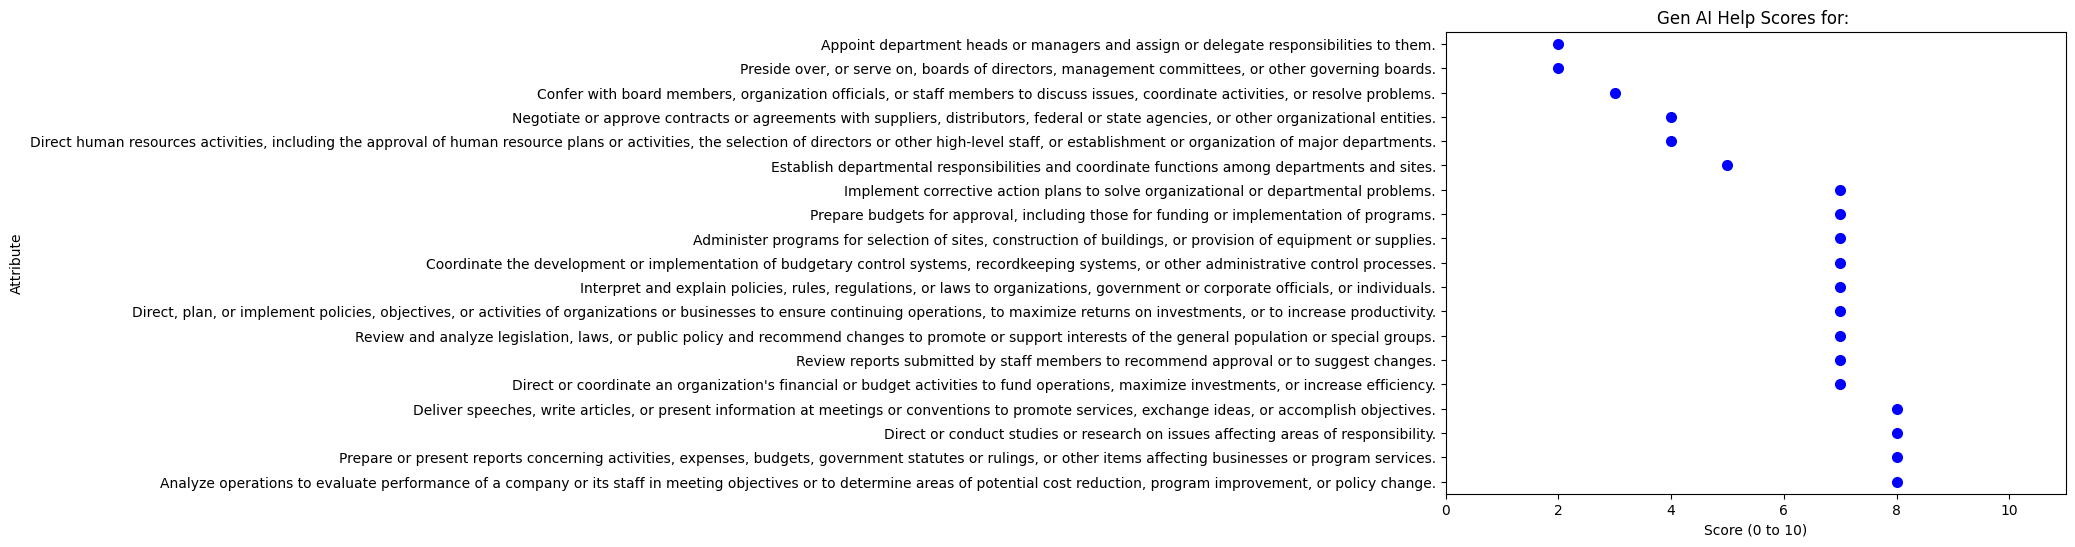

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = results.select("task", "gen_ai_help").to_pandas()
df = df.sort_values(by='answer.gen_ai_help')

plt.figure(figsize=(8, 6))
sns.stripplot(
        x="answer.gen_ai_help",
        y="scenario.task",
        data=df,
        orient="h",
        jitter=False,
        marker="o",
        size=8,
        color="blue",
)
plt.title(f"Gen AI Help Scores for: {combobox.value}")
plt.xlabel("Score (0 to 10)")
plt.ylabel("Attribute")
plt.xlim(0, 11)  #
plt.show()

In [ ]:
def plot_scores(task, score):
    "This plots the scores of the tasks."

    data_dict = {c[1] + f" ({c[0]})": c[2] for c in combined}
    df = pd.DataFrame(list(data_dict.items()), columns=["Attribute", "Score"])
    df = df[df["Score"] > min_score]

    # Create dot chart
    plt.figure(figsize=(8, 6))
    sns.stripplot(
        x="Score",
        y="Attribute",
        data=df,
        orient="h",
        jitter=False,
        marker="o",
        size=8,
        color="blue",
    )
    plt.title(f"Attribute Scores for Question: {question_text}")
    plt.xlabel("Score (0 to 10)")
    plt.ylabel("Attribute")
    plt.xlim(0, 11)  #
    plt.show()

- Need the fraction of time doing that task (from the data?)

- Use the wage for the person as $c_H$. 

- Need to break down the time spent on each sub-task

In [ ]:
class Mock:

    def __init__(self, x):
        self.x = x

    def __repr__(self):
        return f"Mock(x = \"{self.x}\")"

    def __str__(self):
        return "This is string method"

    def _repr_html_(self):
        return "<h1>Hello!</h1>"


x = Mock(x = "Hello world")

In [ ]:
x

Mock(x = "Hello world")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=64accccb-72a8-4cc9-ba99-21217900ce45' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>